In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim # GD를 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현해 주는데, 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 이미지 데이터셋 전처리

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)), # 원본 이미지를 임의의 스케일 범위의 크기만큼으로 자르고, 설정한 resize 크기로 조정
                transforms.RandomHorizontalFlip(), # 기본값이 0.5의 확률로 이미지들을 수평 반전 기킴.
                transforms.ToTensor(), # torchvision의 PIL 라이브러리를 이용하여 이미지를 읽을 때 (H, W, C), [0, 255]로 읽어오는데, ToTensor()로 (C, H, W), [0.0, 1.0]으로 변환
                transforms.Normalize(mean, std) # ImageNet 데이터의 각 채널별 평균과 표준편차에 맞는 정규화 진행.  
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
print(len(os.listdir('../input/cat-and-dog/test_set/test_set/cats/'))) 

1012


In [4]:
cat_directory = '../input/cat-and-dog/training_set/training_set/cats'
dog_directory = '../input/cat-and-dog/training_set/training_set/dogs'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

test_cat_directory = '../input/cat-and-dog/test_set/test_set/cats'
test_dog_directory = '../input/cat-and-dog/test_set/test_set/dogs'

test_cat_images_filepaths = sorted([os.path.join(test_cat_directory, f) for f in os.listdir(test_cat_directory)])
test_dog_images_filepaths = sorted([os.path.join(test_dog_directory, f) for f in os.listdir(test_dog_directory)])

test_images_filepaths = [*test_cat_images_filepaths, *test_dog_images_filepaths]
test_correct_images_filepaths = [i for i in test_images_filepaths if cv2.imread(i) is not None]



random.seed(2022)
random.shuffle(correct_images_filepaths)
random.shuffle(test_correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:6000] 
val_images_filepaths = correct_images_filepaths[6000:]
test_images_filepaths = test_correct_images_filepaths    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

6000 2005 2023


In [5]:
print(os.listdir(cat_directory)[0])
print(cat_directory)
print(os.path.join(cat_directory, os.listdir(cat_directory)[0]))


cat.3498.jpg
../input/cat-and-dog/training_set/training_set/cats
../input/cat-and-dog/training_set/training_set/cats/cat.3498.jpg


In [6]:
print(correct_images_filepaths[0])
print(os.path.normpath(correct_images_filepaths[0]))
true_label = correct_images_filepaths[0].split(os.sep)[-2]
print(true_label)

../input/cat-and-dog/training_set/training_set/dogs/dog.2458.jpg
../input/cat-and-dog/training_set/training_set/dogs/dog.2458.jpg
dogs


In [7]:
def display_image_grid(images_filepaths, predicted_labels = (), cols = 5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = image_filepath.split(os.sep)[-2] # 
        predicted_label = predicted_labels[i] if predicted_labels else true_label 
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color = color)
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()
        

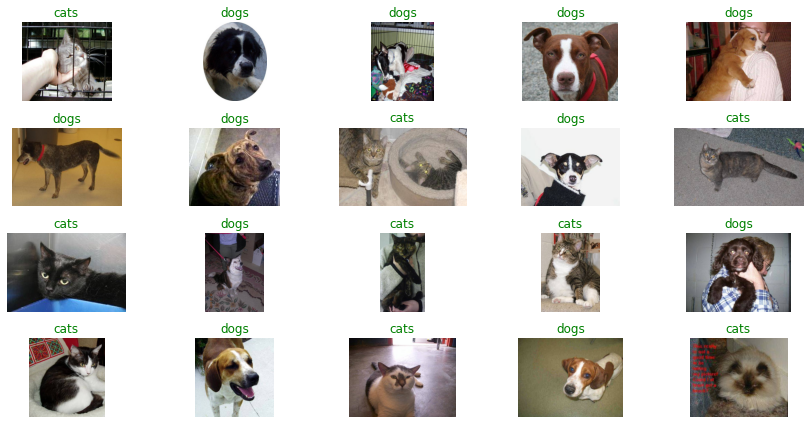

In [8]:
display_image_grid(test_images_filepaths[-20 : ])

In [9]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-1].split('.')[0] # 이러면 label에 cat 혹은 dog 값이 들어간다.
        if label == 'dog':
            label = 1
        elif label == 'cat': 
            label = 0
        
        return img_transformed, label 

In [10]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

## 이미지 데이터셋 정의

In [11]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


## DataLoader 정의

* 파이토치의 데이터로더는 배치 관리를 담당합니다.
* 한번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에, 데이터를 그룹으로 쪼개서 조금씩 불러옵니다. 

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1])


## 모델의 네트워크 클래스 정의

In [14]:
class LeNet(nn.Module):
    def __init__(self,):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1, padding = 0) # (3, 224, 224) -> (16, 220, 220)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 0) # (16, 110, 110) -> (32, 106, 106)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim = 1)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out) #(32, 106, 106) -> (32, 53, 53)
        
        out = out.view(out.size(0), -1) # out.size(0): batch_size. (batch_size, 32, 53, 53) -> (batch_size, 32 * 53 * 53)
        
        out = self.fc1(out) # nn.Linear(32 * 53 * 53, 512)
        out = self.fc2(out)
        out = self.output(out)
        return out 
        

In [16]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [13]:
!pip install torchsummary

In [19]:
from torchsummary import summary

summary(model, input_size = (3, 224, 224), device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

AttributeError: 'torch.device' object has no attribute 'lower'

## 

In [17]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [18]:
model = model.to(device) # 파이토치는 GPU 할당이 자동화되어 있지 않기 때문에, 모델의 모든 파라미터 및 손실 함수가 GPU를 사용할 수 있도록 지정해 주어야 한다. 
criterion = criterion.to(device)

## 모델 학습 함수 정의

In [19]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    return model 
                    

## 모델 학습 

In [20]:
import time

num_epoch = 30
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/30
--------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6755 Acc: 0.5713


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6486 Acc: 0.6204
Epoch 2/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6535 Acc: 0.6128


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6389 Acc: 0.6339
Epoch 3/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6422 Acc: 0.6362


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6431 Acc: 0.6190
Epoch 4/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6333 Acc: 0.6558


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6225 Acc: 0.6529
Epoch 5/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6198 Acc: 0.6653


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5981 Acc: 0.6928
Epoch 6/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6097 Acc: 0.6802


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6052 Acc: 0.6863
Epoch 7/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.6079 Acc: 0.6787


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5821 Acc: 0.7142
Epoch 8/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5953 Acc: 0.6973


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5920 Acc: 0.6978
Epoch 9/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5923 Acc: 0.6972


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5747 Acc: 0.7272
Epoch 10/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5857 Acc: 0.7083


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5663 Acc: 0.7337
Epoch 11/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5806 Acc: 0.7138


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5746 Acc: 0.7192
Epoch 12/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5809 Acc: 0.7142


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5621 Acc: 0.7332
Epoch 13/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5858 Acc: 0.7058


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5668 Acc: 0.7317
Epoch 14/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5715 Acc: 0.7272


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5491 Acc: 0.7501
Epoch 15/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5735 Acc: 0.7185


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5608 Acc: 0.7347
Epoch 16/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5623 Acc: 0.7350


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5471 Acc: 0.7461
Epoch 17/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5591 Acc: 0.7357


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5429 Acc: 0.7566
Epoch 18/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5551 Acc: 0.7400


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5431 Acc: 0.7621
Epoch 19/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5542 Acc: 0.7445


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5414 Acc: 0.7606
Epoch 20/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5504 Acc: 0.7468


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5419 Acc: 0.7571
Epoch 21/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5408 Acc: 0.7608


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5307 Acc: 0.7621
Epoch 22/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5438 Acc: 0.7558


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5333 Acc: 0.7576
Epoch 23/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5438 Acc: 0.7573


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5436 Acc: 0.7516
Epoch 24/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5371 Acc: 0.7630


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5284 Acc: 0.7666
Epoch 25/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5345 Acc: 0.7672


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5265 Acc: 0.7746
Epoch 26/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5320 Acc: 0.7680


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5185 Acc: 0.7805
Epoch 27/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5284 Acc: 0.7713


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5276 Acc: 0.7696
Epoch 28/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5272 Acc: 0.7735


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5171 Acc: 0.7800
Epoch 29/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5276 Acc: 0.7753


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5209 Acc: 0.7825
Epoch 30/30
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 0.5250 Acc: 0.7755


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.5262 Acc: 0.7736
Training complete in 23m 19s
Best val Acc: 0.7825


## 모델 테스트를 위한 함수 정의

In [25]:
import pandas as pd
 
id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타내는 것으로, 훈련 데이터셋의 모델 학습과 가장 큰 차이점입니다. 
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase = 'val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim = 1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
        
res.sort_values(by = 'id', inplace = True)
res.reset_index(drop = True, inplace = True)
        
res.to_csv('./LeNet', index = False )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2023 [00:00<?, ?it/s]

In [26]:
res.head(10)

,id,label
0,4001,0.728518
1,4001,0.354932
2,4002,0.719802
3,4002,0.544367
4,4003,0.286745
5,4003,0.660392
6,4004,0.584830
7,4004,0.730982
8,4005,0.730753
9,4005,0.295422


In [27]:
class_ = classes = {0: 'cat', 1: 'dog'}
def display_image_grid(images_filepaths, predicted_labels = (), cols = 5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5: # dog
            label = 1
        else: # cat
            label = 0 
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

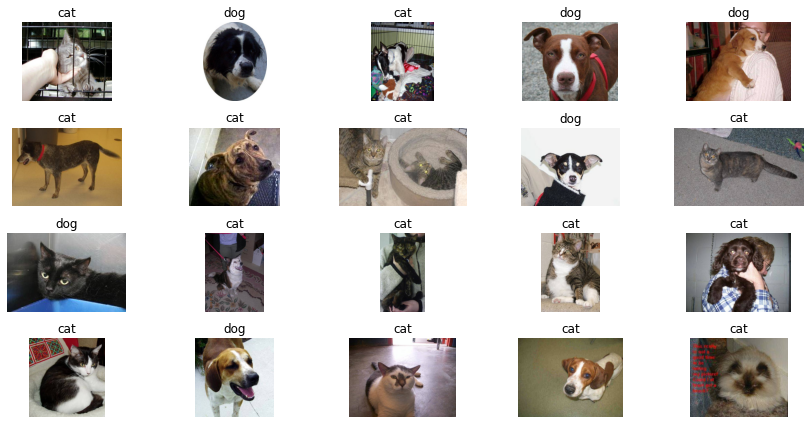

In [29]:
display_image_grid(test_images_filepaths[-20 : ])